In [124]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

from itertools import cycle
from functools import partial
from math import pi
import json
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Imports for working with shapefiles
import pyproj
from shapely.geometry import (
    shape,
    MultiPolygon,
    mapping
)
from shapely.ops import (
    transform,
    cascaded_union
)
import fiona
from fiona.crs import from_epsg

# matplotlib imports
from matplotlib.colors import to_rgb, to_hex
from matplotlib import cm
%matplotlib inline

# local imports
from src.modelling.clustering import SameSizeKMeans
from src.output.shapes import (
    generate_colors,
    plot_shapes,
    generate_shapefiles,
    geojson_from_shapefile
)

In [7]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [8]:
poptot_df = pd.read_csv('data/block_groups/pop_tot/DEC_10_SF1_P1_with_ann.csv')
poptot_df = poptot_df[['GEO.id2', 'D001']]
poptot_df.columns = ['geoid', 'poptot']
poptot_df.drop(0, axis=0, inplace=True)
poptot_df.set_index('geoid', inplace=True)

pop18_df = pd.read_csv('data/block_groups/pop18/DEC_10_SF1_P10_with_ann.csv')
pop18_df = pop18_df[['GEO.id2', 'D001', 'D003']]
pop18_df.columns = ['geoid', 'pop18', 'pop18wht']
pop18_df.drop(0, axis=0, inplace=True)
pop18_df.set_index('geoid', inplace=True)

In [9]:
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': transform(project, shape(block['geometry'])), 
            'geoid': block['properties']['GEOID'],
            'untransformed': shape(block['geometry'])
        }
        for block in f
    ]

In [10]:
for block in blocks:
    block['centroid'] = np.array([coord[0] for coord in block['shape'].centroid.xy])
    block['pop18'] = int(pop18_df.loc[block['geoid']]['pop18'])
    block['pop18wht'] = int(pop18_df.loc[block['geoid']]['pop18wht'])
    block['poptot'] = int(poptot_df.loc[block['geoid']]['poptot'])
    _block_area = block['shape'].area
    block['popdens'] = block['poptot']/_block_area

In [ ]:
# Create shapes of the whole of Wisconsin to be used
# as cutouts for
with fiona.open('data/districts/congressional/Wisconsin_Congressional_Districts.shp') as f:
    wisconsin = cascaded_union([transform(project, shape(district['geometry'])) for district in f])
    wisc_untrans = cascaded_union([shape(district['geometry']) for district in f])

In [27]:
wisc_pop = np.sum([block['poptot'] for block in blocks])
ideal_dist_pop = wisc_pop/8

In [13]:
wisc_untrans.bounds

(-92.8894329062527, 42.49191474914349, -86.76398658736599, 47.08077430717272)

In [5]:
def cleanup_blocks(blocks, labels):
    dist_blocks = {
    label: [block for block in blocks
            if block['label'] == label]
    for label in np.unique(labels)
    }
    
    for label in dist_blocks:
        _blocks = dist_blocks[label]
        for block in _blocks:
            if block['iscontiguous']:
                continue
            for other_block in _blocks:
                if block['geoid'] != other_block['geoid']:
                    if block['shape'].touches(other_block['shape']):
                        block['iscontiguous'] = True
                        other_block['iscontiguous'] = True
                        break
                    else:
                        block['iscontiguous'] = False
    
    for block in blocks:
        votes = defaultdict(int)
        if block['iscontiguous']:
            continue
        for other_block in blocks:
            if other_block['geoid'] == block['geoid']:
                continue
            if other_block['shape'].touches(block['shape']):
                votes[other_block['label']] +=1
        new_label = max(votes, key=votes.get)
        block['label'] = new_label

In [11]:
coord_array = np.array([block['centroid'] for block in blocks])
weight_array = np.array([block['poptot'] for block in blocks])

In [53]:
epsg_spec = 4326
schema = {
    'type': 'Feature',
    'geometry': 'Polygon',
    'properties': {
        'id': 'int',
        'id_color': 'str',
        'cmpctness': 'float',
        'cmpct_col': 'str',
        'popdiff': 'float',
        'pdiff_col': 'str',
        'poptot': 'int',
        'pop18': 'int',
        'pop18wht': 'int'
    }
}
all_schema_values = [
    {
        'type': 'Feature',
        'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
        'properties': {
            'id': district['id'],
            'id_color': hex_dist_colors[district['id']],
            'cmpctness': district['compactness'],
            'cmpct_col': cmpct_hex_colors[district['id']],
            'popdiff': district['popdiff'],
            'pdiff_col': popdiff_hex_colors[district['id']],
            'poptot': district['poptot'],
            'pop18': district['pop18'],
            'pop18wht': district['pop18wht']
        }
    }
    for district in districts
]
file_folder = 'data/districts/generated/kmeans'
with fiona.open('data/districts/generated/kmeans', 'w', 'ESRI Shapefile', schema, crs=crs) as c:
    for district in districts:
        c.write({
            'type': 'Feature',
            'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
            'properties': {
                'id': district['id'],
                'id_color': hex_dist_colors[district['id']],
                'cmpctness': district['compactness'],
                'cmpct_col': cmpct_hex_colors[district['id']],
                'popdiff': district['popdiff'],
                'pdiff_col': popdiff_hex_colors[district['id']],
                'poptot': district['poptot'],
                'pop18': district['pop18'],
                'pop18wht': district['pop18wht']
            }
        })

In [54]:
with fiona.collection("data/districts/generated/kmeans/kmeans.shp", "r") as source:
    features = [feature for feature in source]
    crs = " ".join("+{}={}".format(key,value) for key, value in source.crs.items())
    
for feature in features:
    feature['geometry'] = mapping(
        shape(feature['geometry']).simplify(4e-3)
    )

In [55]:
my_layer = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {
        "type": "link", 
        "properties": {"href": "kmeans_districts.crs", "type": "proj4"}
    }
}

with open("src/static/geojson/kmeans_districts.json", "w") as f:
    f.write(unicode(json.dumps(my_layer)))
with open("src/static/geojson/kmeans_districts.crs", "w") as f:
    f.write(unicode(crs))

In [57]:
sskmeans = SameSizeKMeans(n_clusters=8, save_labels=True)
sskmeans.fit(
    coord_array, weights=weight_array,
    weight_tol=2e-3, order='s')

Starting step  0
Starting step  1
Starting step  2
Starting step  3
Starting step  4
Starting step  5
Starting step  6


In [122]:
len(sskmeans.all_labels_)

8

Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop
Bloop


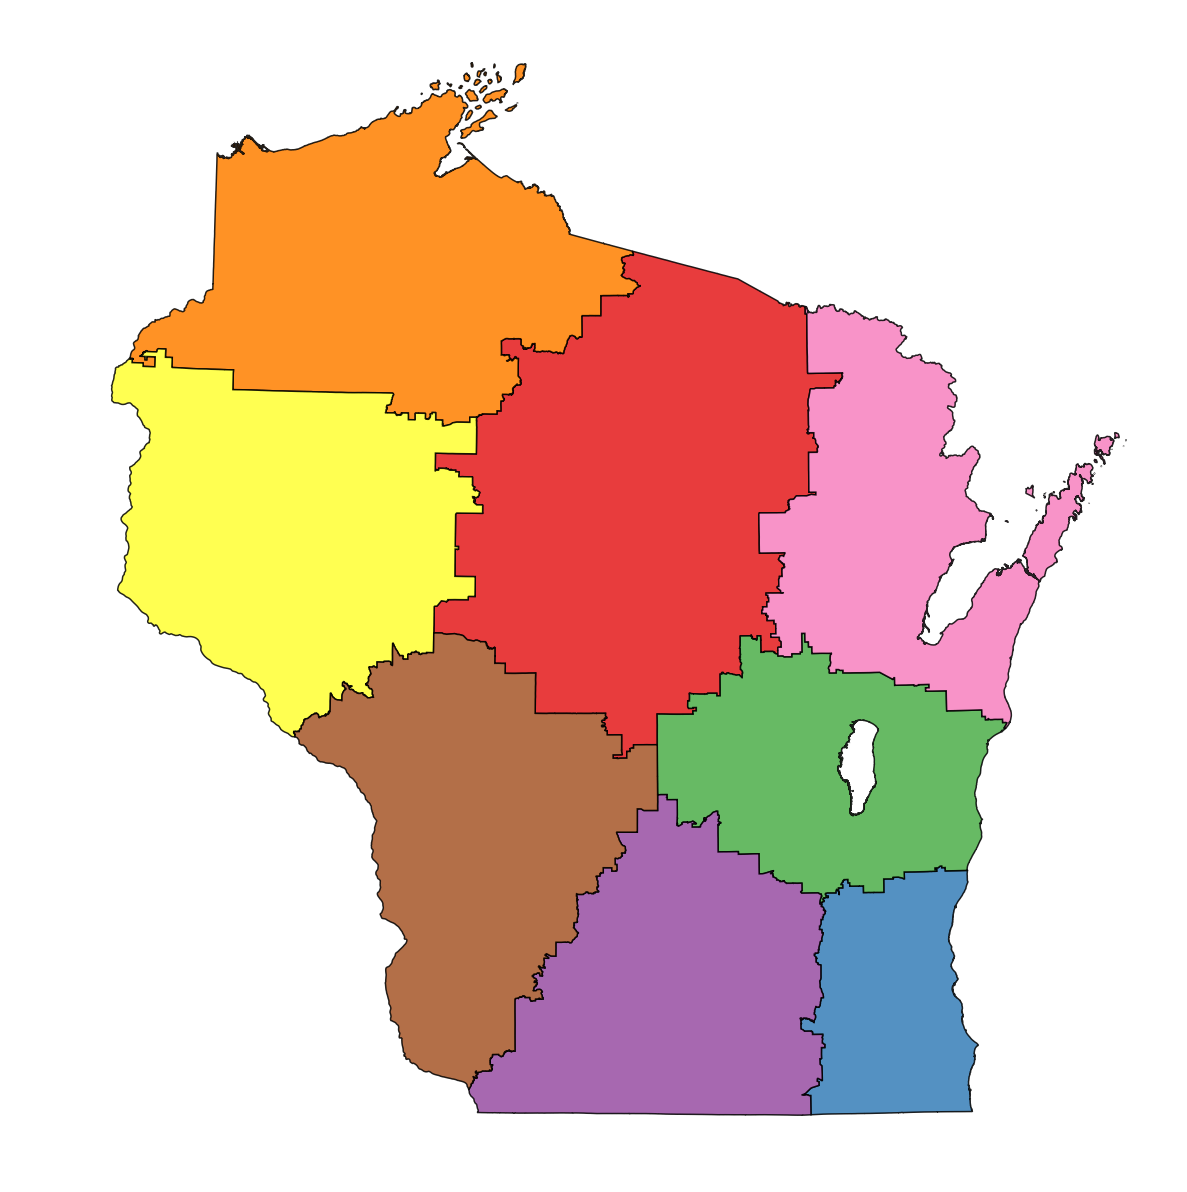

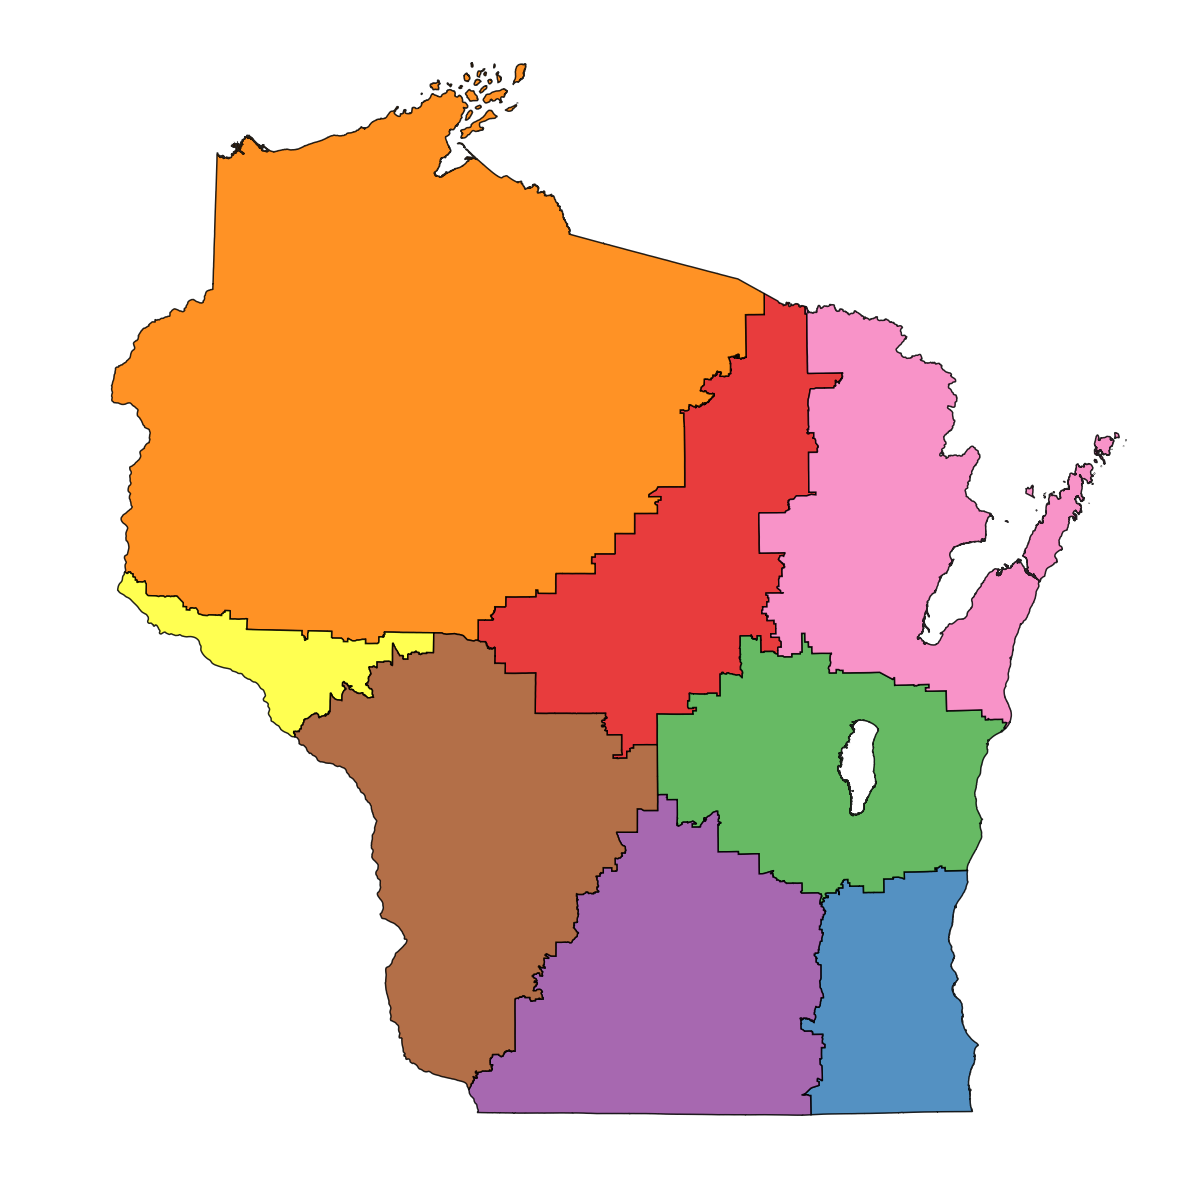

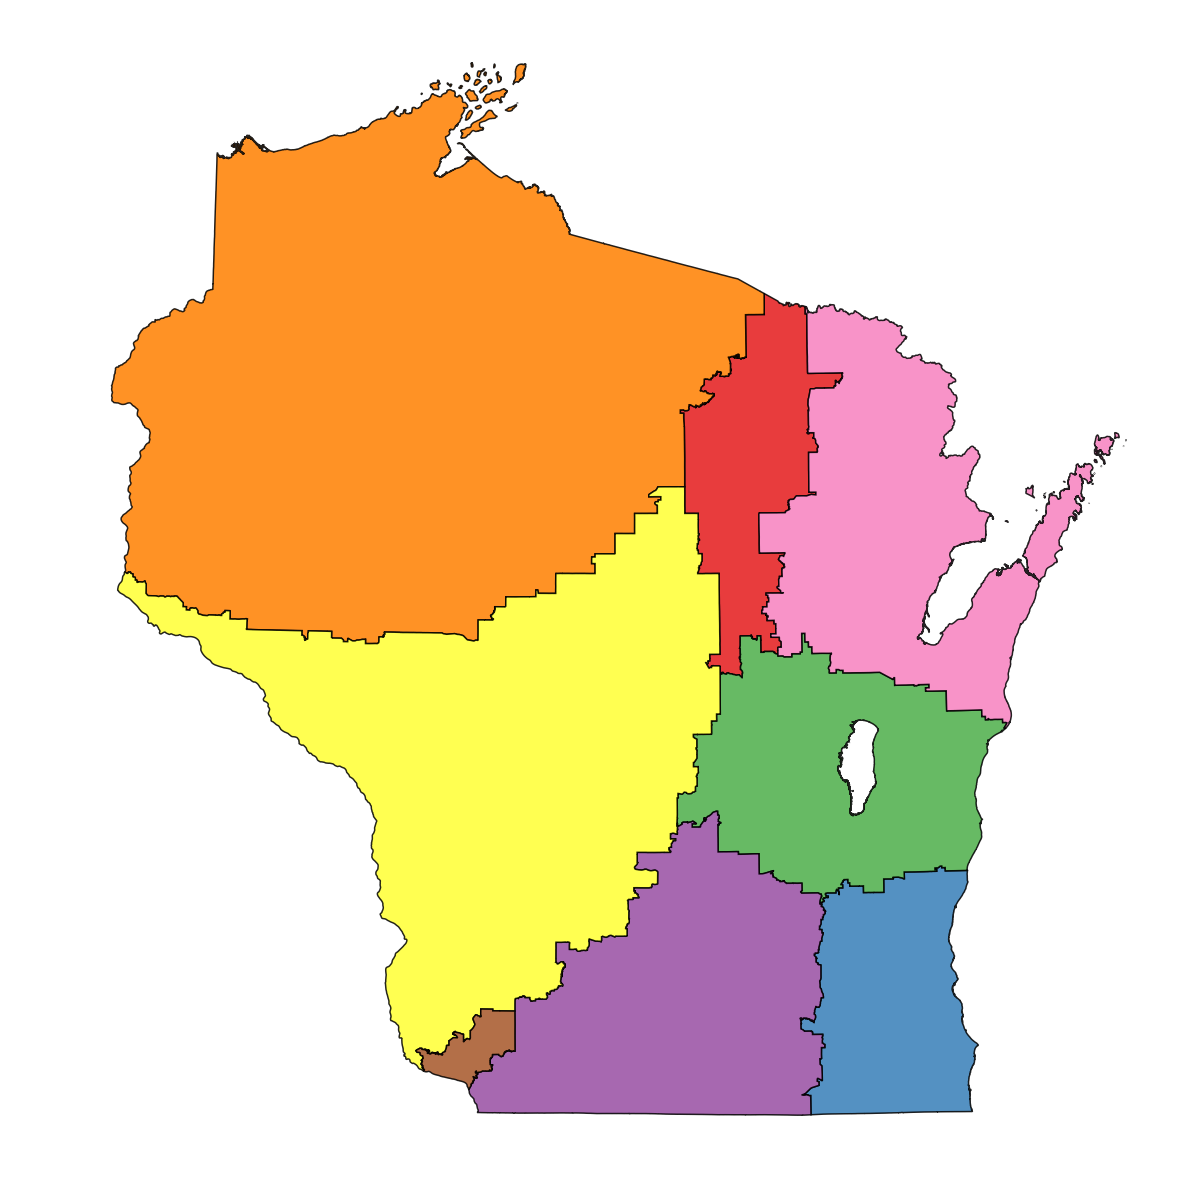

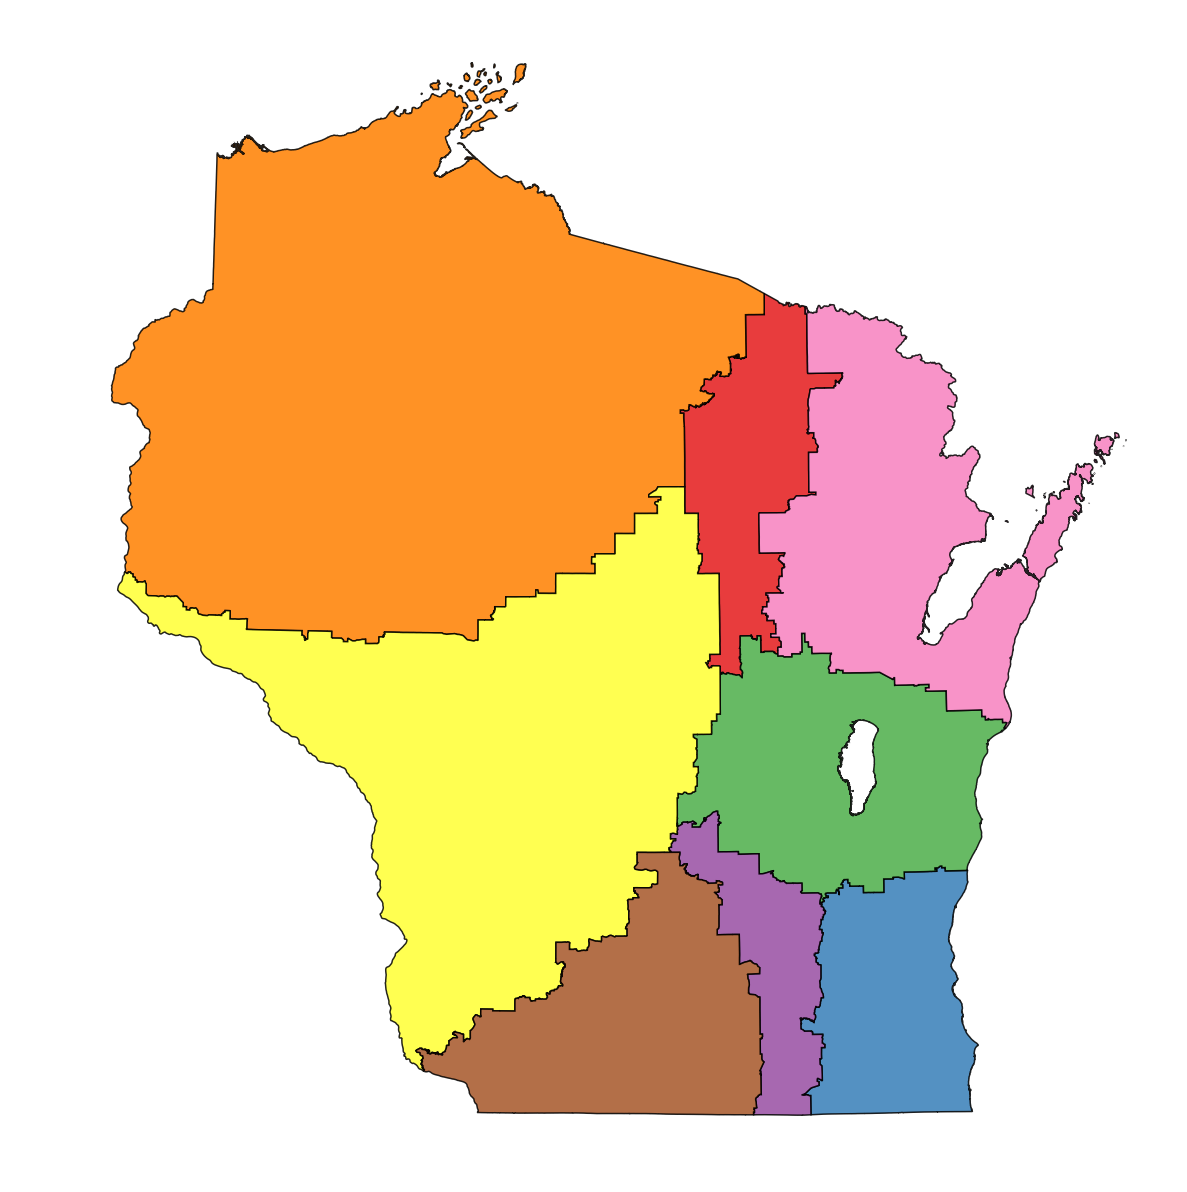

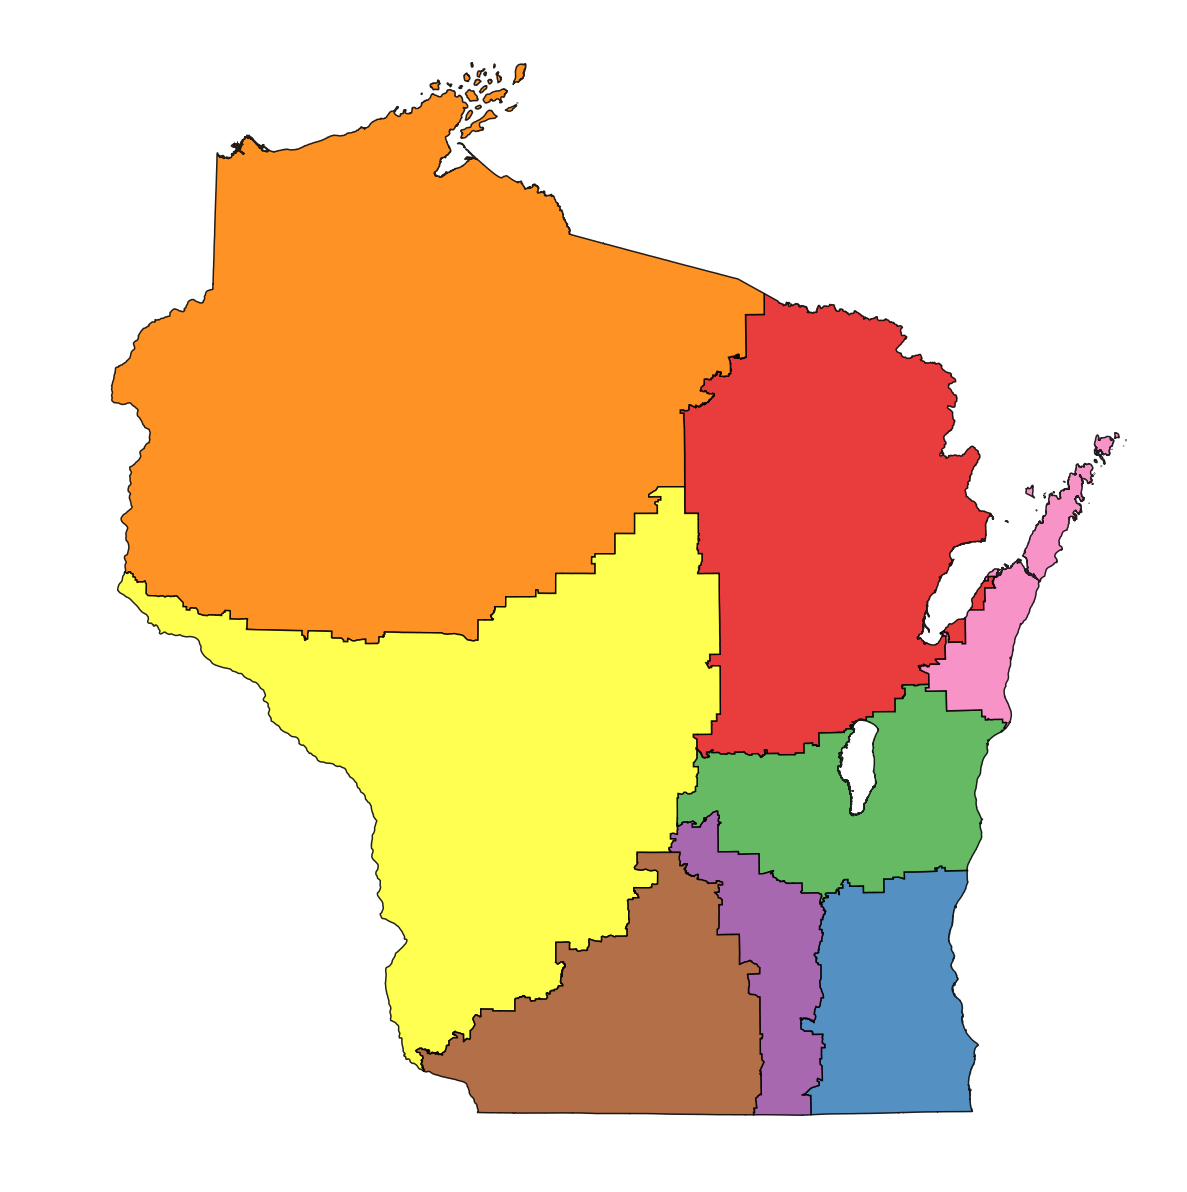

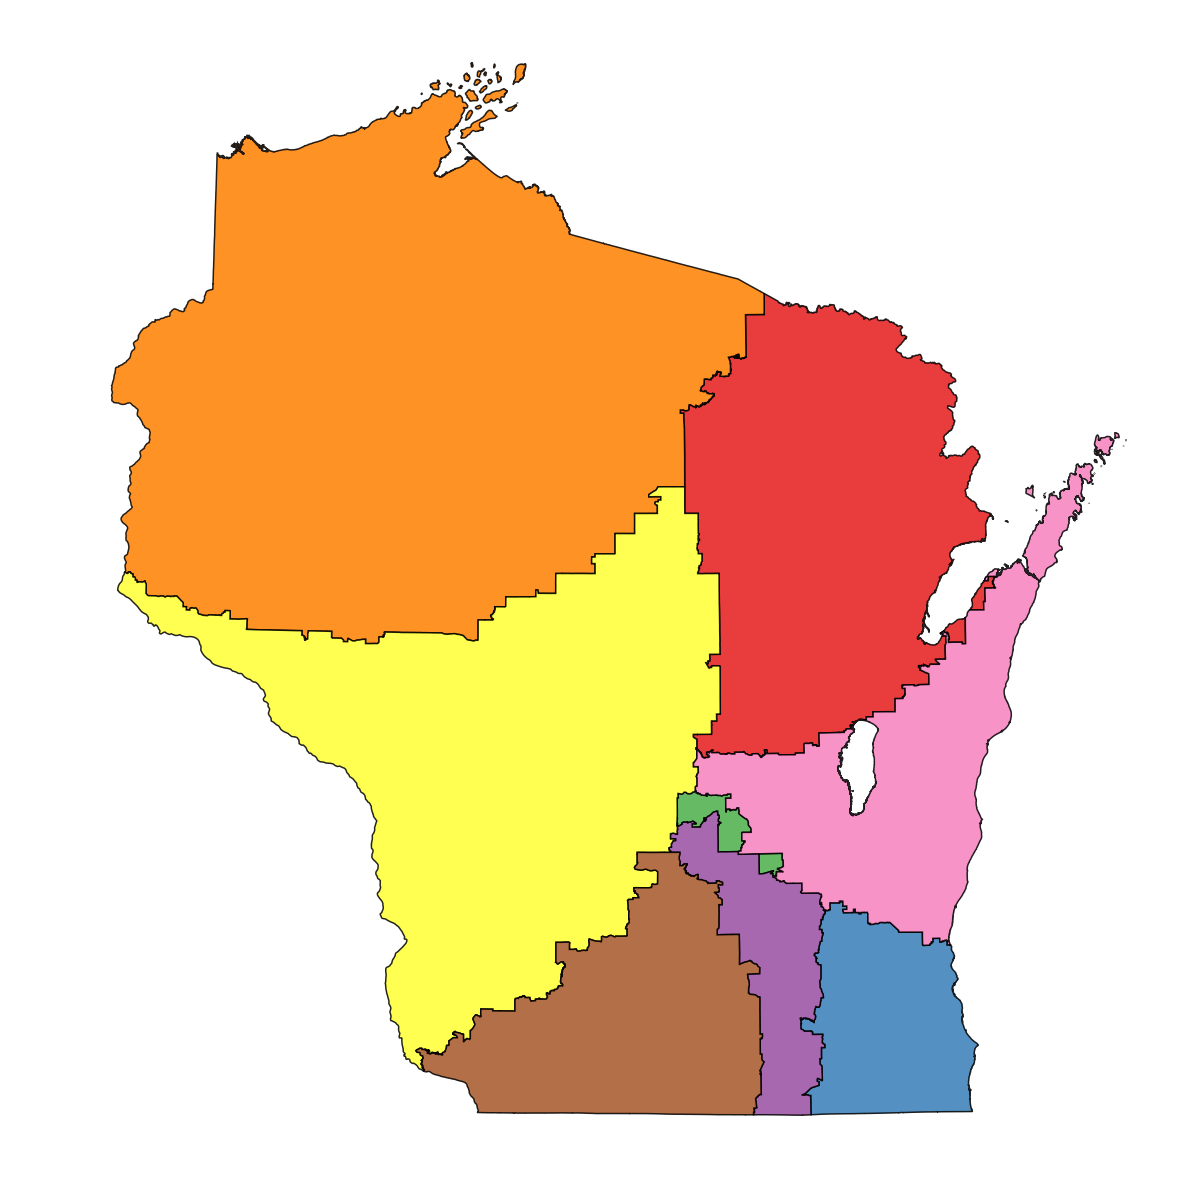

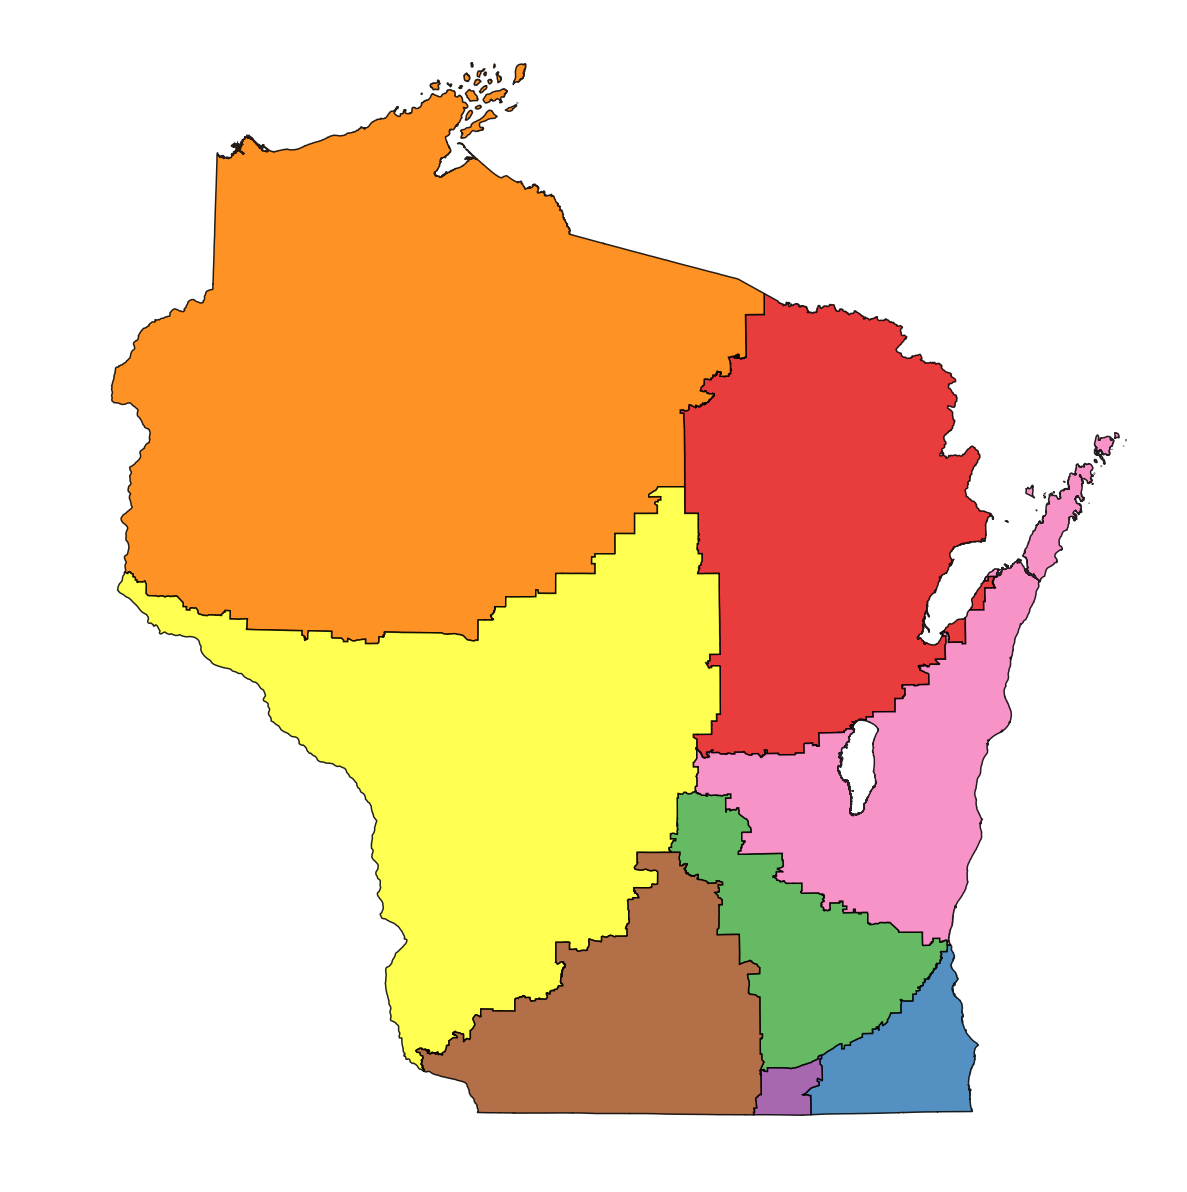

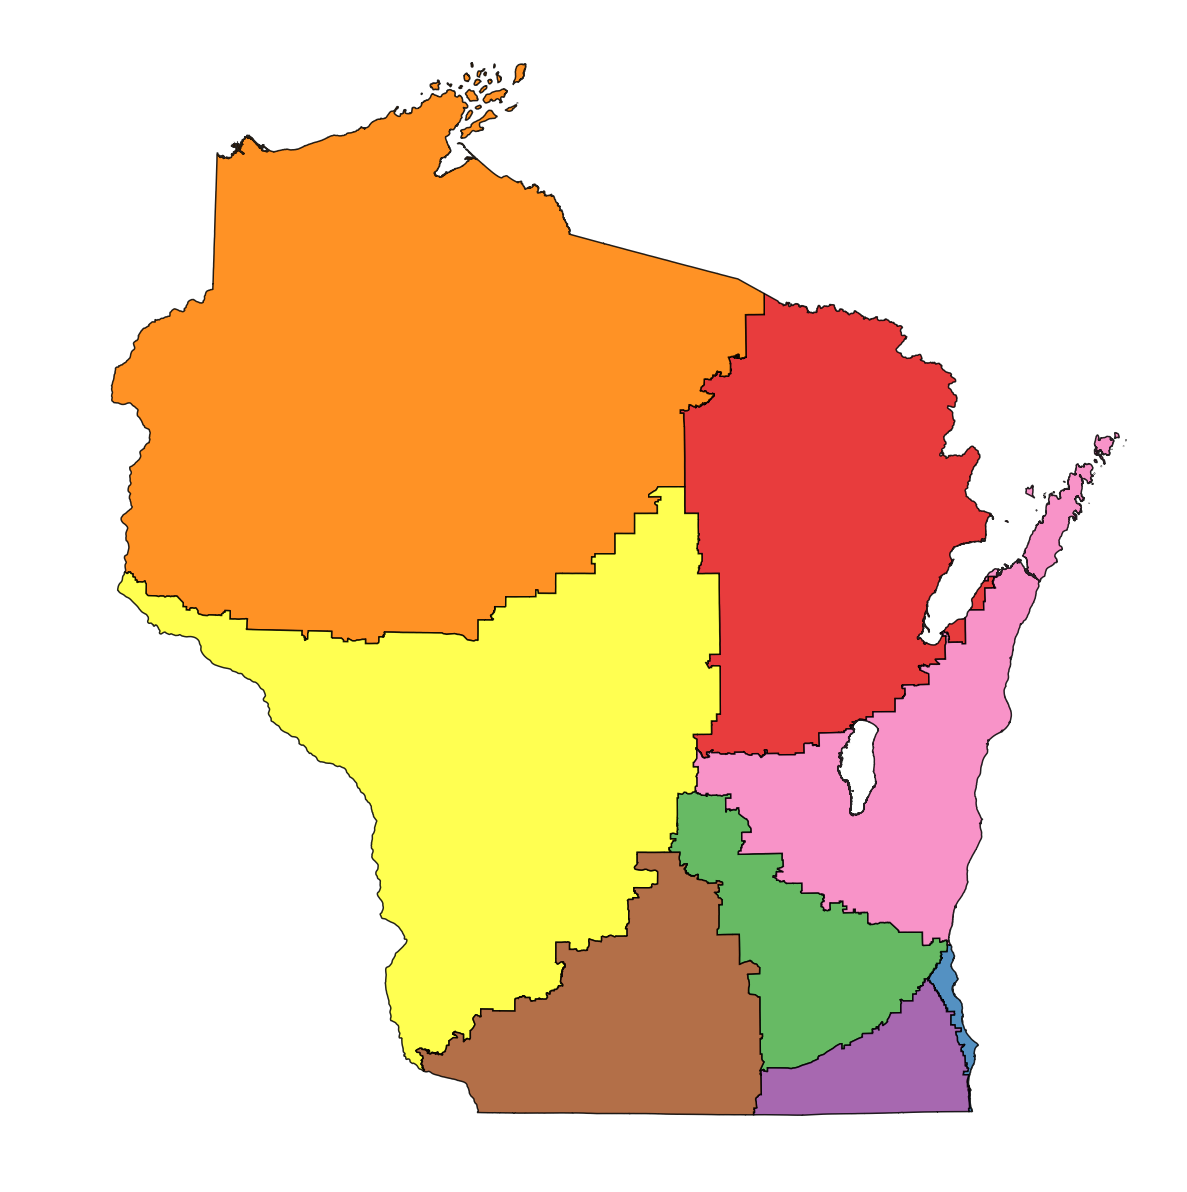

In [58]:
# Get the order that SSKMeans was run in
_order = sskmeans.order

# Make images for each step of the SSKMeans process
# Step 0 is the initial Naive KMeans step
for step in range(8):
    labels = sskmeans.all_labels_[step]
    for label, block in zip(labels, blocks):
        block['label'] = int(label)
        block['iscontiguous'] = False

    for label in np.unique(labels):
        _label_pop = np.sum(
            [block['poptot'] for block in blocks if block['label'] == label])

    while not all([block['iscontiguous'] for block in blocks]):
        print('Cleaning up blocks')
        cleanup_blocks(blocks, labels)

    new_districts = [{} for label in np.unique(labels)]
    for i, label in enumerate(np.unique(labels)):
        new_districts[i]['shape'] = cascaded_union(
            [block['shape'] for block in blocks if block['label'] == label]
        )

        new_districts[i]['untransformed'] = cascaded_union([
            block['untransformed']
            for block in blocks
            if block['label'] == label
        ])

    hex_colors = [
        '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
        '#ff7f00', '#ffff33', '#a65628', '#f781bf'
    ]
    district_colors = [to_rgb(color) for color in hex_colors]

    kmeans_file = 'images/samesize_kmeans_{}_step{}.png'.format(_order,step)
    plot_shapes(new_districts, district_colors, fig_file=kmeans_file)

In [113]:
labels = sskmeans.final_labels
for label, block in zip(labels, blocks):
    block['label'] = int(label)
    block['iscontiguous'] = False
    

while not all([block['iscontiguous'] for block in blocks]):
    print('Cleaning up blocks')
    cleanup_blocks(blocks, labels)

districts = [{} for label in np.unique(labels)]
for label in np.unique(labels):
    districts[label]['shape'] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])
    
    districts[label]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])
    districts[label]['id'] = int(label) + 1

wisc_pop = np.sum([block['poptot'] for block in blocks])
ideal_dist_pop = wisc_pop/8

for label in np.unique(labels):
    _tot_pop = np.sum([block['poptot'] for block in blocks if block['label'] == label])
    districts[label]['poptot'] = _tot_pop
    
    _tot_pop18 = np.sum([block['pop18'] for block in blocks if block['label'] == label])
    districts[label]['pop18'] = _tot_pop18
    
    _tot_pop18wht = np.sum([block['pop18wht'] for block in blocks if block['label'] == label])
    districts[label]['pop18wht'] = _tot_pop18wht
    
    _area = districts[label]['shape'].area/(1000)**2
    _perimeter = districts[label]['shape'].length/1000
    districts[label]['compactness'] = (4*pi*_area/_perimeter**2)
    
    _pop_diff = _tot_pop - ideal_dist_pop
    districts[label]['popdiff'] = (1 + _pop_diff/ideal_dist_pop/popdiff_ref)/2
    
print(ideal_dist_pop, _tot_pop)

hex_dist_colors = {
    district['id']: to_hex(cm.Set1(district['id'] - 1))
    for district in districts
}
ref_aspect = 1.5
reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
cmpct_hex_colors = {
    district['id']: to_hex(cm.Reds_r(district['compactness']/reference))
    for district in districts
}
popdiff_hex_colors = {
    district['id']: to_hex(cm.seismic(district['popdiff']))
    for district in districts
}

crs = from_epsg(4326)
schema = {
    'type': 'Feature',
    'geometry': 'Polygon',
    'properties': {
        'id': 'int', 'id_color': 'str',
        'cmpctness': 'float', 'cmpct_col': 'str',
        'popdiff': 'float', 'pdiff_col': 'str',
        'poptot': 'int', 'pop18': 'int', 'pop18wht': 'int'
    }
}
with fiona.open('data/districts/generated/sskmeans', 'w', 'ESRI Shapefile', schema, crs=crs) as c:
    for district in districts:
            c.write({
                'type': 'Feature',
                'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
                'properties': {
                    'id': district['id'],
                    'id_color': hex_dist_colors[district['id']],
                    'cmpctness': district['compactness'],
                    'cmpct_col': cmpct_hex_colors[district['id']],
                    'popdiff': district['popdiff'],
                    'pdiff_col': popdiff_hex_colors[district['id']],
                    'poptot': district['poptot'],
                    'pop18': district['pop18'],
                    'pop18wht': district['pop18wht']
                }
            })

with fiona.collection("data/districts/generated/sskmeans/sskmeans.shp", "r") as source:
    features = [feature for feature in source]
    crs = " ".join("+{}={}".format(key,value) for key, value in source.crs.items())
    
for feature in features:
    feature['geometry'] = mapping(
        shape(feature['geometry']).simplify(4e-3)
    )

my_layer = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {
        "type": "link", 
        "properties": {"href": "sskmeans_districts.crs", "type": "proj4"}
    }
}

with open("src/static/geojson/sskmeans_districts.json", "w") as f:
    f.write(unicode(json.dumps(my_layer)))
with open("src/static/geojson/sskmeans_districts.crs", "w") as f:
    f.write(unicode(crs))

Cleaning up blocks
Cleaning up blocks
710873.25 707450


In [114]:
labels = sskmeans.all_labels_[0]
for label, block in zip(labels, blocks):
    block['label'] = int(label)
    block['iscontiguous'] = False
    

while not all([block['iscontiguous'] for block in blocks]):
    print('Cleaning up blocks')
    cleanup_blocks(blocks, labels)

districts = [{} for label in np.unique(labels)]
for label in np.unique(labels):
    districts[label]['shape'] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])
    
    districts[label]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])
    districts[label]['id'] = int(label) + 1

for label in np.unique(labels):
    _tot_pop = np.sum([block['poptot'] for block in blocks if block['label'] == label])
    districts[label]['poptot'] = _tot_pop
    
    _tot_pop18 = np.sum([block['pop18'] for block in blocks if block['label'] == label])
    districts[label]['pop18'] = _tot_pop18
    
    _tot_pop18wht = np.sum([block['pop18wht'] for block in blocks if block['label'] == label])
    districts[label]['pop18wht'] = _tot_pop18wht
    
    _area = districts[label]['shape'].area/(1000)**2
    _perimeter = districts[label]['shape'].length/1000
    districts[label]['compactness'] = (4*pi*_area/_perimeter**2)
    
    _pop_diff = _tot_pop - ideal_dist_pop
    districts[label]['popdiff'] = (1 + _pop_diff/ideal_dist_pop/popdiff_ref)/2
    
print(ideal_dist_pop, _tot_pop)

hex_dist_colors = {
    district['id']: to_hex(cm.Set1(district['id'] - 1))
    for district in districts
}
ref_aspect = 1.5
reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
cmpct_hex_colors = {
    district['id']: to_hex(cm.Reds_r(district['compactness']/reference))
    for district in districts
}
popdiff_hex_colors = {
    district['id']: to_hex(cm.seismic(district['popdiff']))
    for district in districts
}

crs = from_epsg(4326)
schema = {
    'type': 'Feature',
    'geometry': 'Polygon',
    'properties': {
        'id': 'int', 'id_color': 'str',
        'cmpctness': 'float', 'cmpct_col': 'str',
        'popdiff': 'float', 'pdiff_col': 'str',
        'poptot': 'int', 'pop18': 'int', 'pop18wht': 'int'
    }
}
with fiona.open('data/districts/generated/kmeans', 'w', 'ESRI Shapefile', schema, crs=crs) as c:
    for district in districts:
            c.write({
                'type': 'Feature',
                'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
                'properties': {
                    'id': district['id'],
                    'id_color': hex_dist_colors[district['id']],
                    'cmpctness': district['compactness'],
                    'cmpct_col': cmpct_hex_colors[district['id']],
                    'popdiff': district['popdiff'],
                    'pdiff_col': popdiff_hex_colors[district['id']],
                    'poptot': district['poptot'],
                    'pop18': district['pop18'],
                    'pop18wht': district['pop18wht']
                }
            })

with fiona.collection("data/districts/generated/kmeans/kmeans.shp", "r") as source:
    features = [feature for feature in source]
    crs = " ".join("+{}={}".format(key,value) for key, value in source.crs.items())
    
for feature in features:
    feature['geometry'] = mapping(
        shape(feature['geometry']).simplify(4e-3)
    )


my_layer = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {
        "type": "link", 
        "properties": {"href": "kmeans_districts.crs", "type": "proj4"}
    }
}

with open("src/static/geojson/kmeans_districts.json", "w") as f:
    f.write(unicode(json.dumps(my_layer)))
with open("src/static/geojson/kmeans_districts.crs", "w") as f:
    f.write(unicode(crs))

Cleaning up blocks
Cleaning up blocks
710873.25 444261


In [125]:
all_labels = sskmeans.all_labels_

In [ ]:
for step, labels in enumerate(all_labels):
    
    # Assign labels to each blockgroup for current step
    for label, block in zip(labels, blocks):
        block['label'] = int(label)
        block['iscontiguous'] = False
    
    # Make blockgroups contiguous
    while not all([block['iscontiguous'] for block in blocks]):
        print('Cleaning up blocks')
        cleanup_blocks(blocks, labels)
        
    # Create a dictionary of districts by label, and assign
    # their shape to be the union of all the blocks with
    # that label
    districts = [{} for label in np.unique(labels)]
    for label in np.unique(labels):
        districts[label]['shape'] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])

        districts[label]['untransformed'] = cascaded_union([
            block['untransformed']
            for block in blocks
            if block['label'] == label
        ])
        districts[label]['id'] = int(label) + 1